In [1]:
import warnings
warnings.filterwarnings('ignore') 

import numpy as np
import pandas as pd
from collections import Counter
import cv2, os
from tqdm import tqdm
from random import shuffle
import shutil
import re
import datetime
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn import utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip
from tensorflow.keras import layers

from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from wandb.keras import WandbCallback
import imgaug.augmenters as iaa

# Importing Modules

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from data_generator import *
from functions_generator import *

In [4]:
#from customized_adaboost import AdaBoostClassifier as Ada_CNN


In [27]:
# from truth_adaboost import AdaBoostClassifier as Ada_CNN
from custom_model import AdaBoostClassifier as Ada_CNN


In [6]:
from constants import *

# Wandb

In [7]:
# For MLOps
import wandb
print("W&B: ", wandb.__version__)
from wandb.keras import WandbCallback
wandb.login(key='236eaeacc7d9dd51a618dca240c24e304f5ad256',relogin=True)

W&B:  0.13.5


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\UsuarioHI/.netrc


True

In [8]:
# Dataset EyeQ
train_quality = pd.read_csv(root_path + 'data/Label_EyeQ_train.csv')
test_quality = pd.read_csv(root_path + 'data/Label_EyeQ_test.csv' )

# Selecciono imágenes que sean gradables y usables
train_quality = train_quality.loc[(train_quality['quality']==0) | (train_quality['quality']==1)]

train_quality['Referible'] = np.where((train_quality['DR_grade']==0) | (train_quality['DR_grade']==1), 0, 1)

# Selecting images

In [9]:
# De aquellas imágenes que sean usables y calificables, seleccionar las primeras 5 por cada target de retinopatía
images_include = list(train_quality.loc[(train_quality['quality']==0) | (train_quality['quality']==1)].groupby('DR_grade').head(6)['image'].unique())


train_quality = train_quality.loc[train_quality['image'].isin(images_include)]

train_quality.groupby('Referible')['DR_grade'].value_counts()

Referible  DR_grade
0          0           6
           1           6
1          2           6
           3           6
           4           6
Name: DR_grade, dtype: int64

# Train test split

In [10]:
train_quality = train_quality.reset_index()
train_quality['ID'] = train_quality.image.apply(lambda x: re.findall(r'\d+', x)[0])

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

list_imgs = np.array(train_quality['image'])
list_labels = np.array(train_quality['Referible'])

groups = train_quality['ID']

# me aseguro que estén las imágenes de un solo paciente de un lado ó del otro
for i, (train_index, test_index) in enumerate(
        gss.split(train_quality['image'], train_quality['Referible'], groups=train_quality['ID'])):
    train_idx = train_index
    test_idx = test_index

print("Cantidad indices de train", len(train_index))
print("Cantidad indices de test", len(test_index))

X_train = train_quality.loc[train_quality.index.isin(train_idx)].image
y_train = train_quality.loc[train_quality.index.isin(train_idx)]['Referible']

X_test = train_quality.loc[train_quality.index.isin(test_idx)].image
y_test = train_quality.loc[train_quality.index.isin(test_idx)]['Referible']

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

Cantidad indices de train 19
Cantidad indices de test 11


In [11]:
training_generator = DataGeneratorNext(X_train, y_train, **params_train)
valid_generator = DataGeneratorNext(X_test, y_test, **params_valid)

In [30]:
len(training_generator)

9

In [12]:
np.unique(y_train)

array([0, 1])

In [13]:
img,target = next(training_generator)

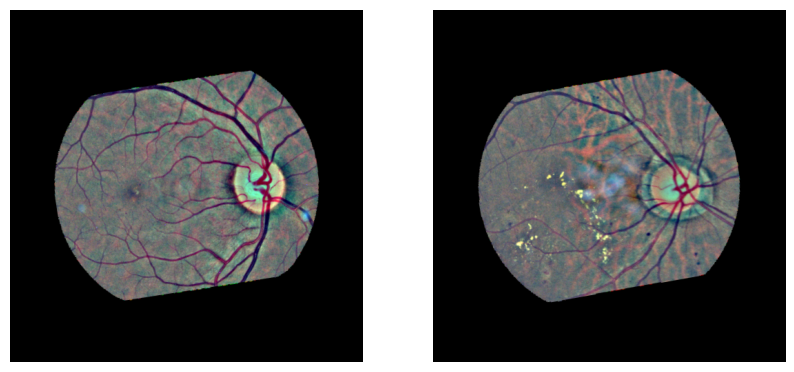

In [14]:
plt.figure(figsize=(10,6))
for i in range(len(img)):
    plt.subplot(1,2,i+1), plt.imshow(img[i])
    plt.axis('off')
plt.show()

# Model

In [15]:
def get_model(parameters):
    base_model = keras.applications.VGG16(
                                    weights=parameters['weights'],  
                                    input_shape=parameters['input_shape_model'],
                                    include_top=parameters['include_top'])

    base_model.trainable = parameters['trainable']


    # Freezing weights
    x = base_model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation=tf.nn.relu)(x)
    x = Dropout(parameters['dropout'])(x)
    x = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
    x = Dropout(parameters['dropout'])(x)
    outputs = tf.keras.layers.Dense(1, activation=parameters['output_activation'])(x)
    model = keras.Model(inputs=base_model.input, outputs=outputs)

    return model

# Probar por separado Adaboost customized

In [37]:
n_estimators=10
epochs=1
bdt_real_test_CNN = Ada_CNN(
    base_estimator=get_model(params),
    n_estimators=n_estimators,
    learning_rate=1,
    epochs=epochs)

In [17]:
X1,y1 = next(training_generator)

In [23]:
n_samples = X1.shape[0]

In [24]:
n_samples

2

In [104]:
sample_weight = np.ones(n_samples) / n_samples

In [26]:
sample_weight

array([0.5, 0.5])

In [97]:
base_estimator0 = get_model(params)

In [28]:
from keras.models import Sequential

In [98]:
config=base_estimator0.get_config()
#estimator = Models.model_from_config(config)
estimator1 = Sequential.from_config(config)


weights = base_estimator0.get_weights()
estimator1.set_weights(weights)
estimator1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
from sklearn.preprocessing import LabelBinarizer


In [31]:
lb=LabelBinarizer()
y_b = lb.fit_transform(y1)

Hace el fit en el sample training (batch) por cada n_estimator

In [100]:
estimator1.fit(X1, y_b, sample_weight=sample_weight, epochs = 1, batch_size = 2)

1/1 [==============================] - 6s 6s/step - loss: 0.2958 - accuracy: 0.5000


In [117]:
y_pred = estimator1.predict(X1) # 2 imgs, 2 predictions


1/1 [==============================] - 1s 1s/step


In [119]:
y_b

array([[0],
       [1]])

In [118]:
y_pred

array([[0.33740652],
       [0.32109648]], dtype=float32)

In [102]:
y_pred_l = np.where(y_pred>0.5,1,0)
incorrect = y_pred_l != y_b
estimator_error = np.dot(incorrect.reshape(1,-1), sample_weight) / np.sum(sample_weight, axis=0)


In [103]:
estimator_error

array([0.50028561])

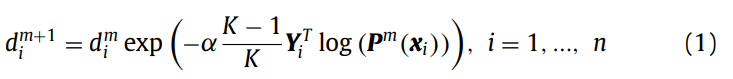

In [106]:
from numpy.core.umath_tests import inner1d
sample_weight = sample_weight*np.exp(-1. * bdt_real_test_CNN.learning_rate_ * (((2 - 1) / 2) *
                                                        inner1d(y_b, np.log(
                                                            y_pred)))) 

sample_weight_sum = np.sum(sample_weight, axis=0)
sample_weight /= sample_weight_sum



In [107]:
sample_weight

array([0.36169687, 0.63830313])

In [109]:
base_estimator1= estimator1
config=base_estimator1.get_config()
#estimator = Models.model_from_config(config)
estimator2 = Sequential.from_config(config)


weights = base_estimator1.get_weights()
estimator2.set_weights(weights)
estimator2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [133]:
h = estimator2.fit(X1, y_b, sample_weight=sample_weight, epochs = 1, batch_size = 2)

1/1 [==============================] - 6s 6s/step - loss: 1569.8411 - accuracy: 0.5000


In [111]:
y_pred = estimator2.predict(X1) # 2 imgs, 2 predictions

1/1 [==============================] - 1s 1s/step


In [113]:
y_pred_l = np.where(y_pred>0.5,1,0)
incorrect = y_pred_l != y_b
estimator_error = np.dot(incorrect.reshape(1,-1), sample_weight) / np.sum(sample_weight, axis=0)

In [120]:
incorrect

array([[ True],
       [False]])

In [114]:
estimator_error

array([0.36169687])

In [115]:
sample_weight = sample_weight*np.exp(-1. * bdt_real_test_CNN.learning_rate_ * (((2 - 1) / 2) *
                                                        inner1d(y_b, np.log(
                                                            y_pred)))) 

sample_weight_sum = np.sum(sample_weight, axis=0)
sample_weight /= sample_weight_sum

In [116]:
sample_weight

array([0.36169687, 0.63830313])

# Customized adaboost

In [19]:
X_train.shape[0]

19

In [58]:
n_estimators=1
epochs=4
bdt_real_test_CNN = Ada_CNN(
    base_estimator=get_model(params),
    n_estimators=n_estimators,
    learning_rate=1,
    epochs=4,
    sample_size=X_train.shape[0])

In [24]:
len(training_generator[0])

2

In [68]:
X_train.shape

(19,)

In [64]:
len(training_generator)

9

In [28]:
x,y = next(training_generator)

In [29]:
x,y = training_generator[0]

In [59]:
bdt_real_test_CNN.fit(training_generator=training_generator)


Entrenamiento de la epoch nro 0
Entrenamiento del batch nro 0
Estimator nro:  0
New sample_weights:  [1. 1.]
1/1 [==============================] - 7s 7s/step - loss: 0.8928 - accuracy: 0.5000 - get_recall: 0.0000e+00 - get_f1_score: 0.0000e+00 - get_precision: 0.0000e+00
Entrenamiento del batch nro 1
Estimator nro:  0
New sample_weights:  [1. 1.]
1/1 [==============================] - 6s 6s/step - loss: 2.7969 - accuracy: 0.0000e+00 - get_recall: 0.0000e+00 - get_f1_score: 0.0000e+00 - get_precision: 0.0000e+00
Entrenamiento del batch nro 2
Estimator nro:  0
New sample_weights:  [1. 1.]
1/1 [==============================] - 6s 6s/step - loss: 24.3196 - accuracy: 0.5000 - get_recall: 1.0000 - get_f1_score: 0.6667 - get_precision: 0.5000
Entrenamiento del batch nro 3
Estimator nro:  0
New sample_weights:  [1. 1.]
1/1 [==============================] - 6s 6s/step - loss: 3.9324 - accuracy: 0.0000e+00 - get_recall: 0.0000e+00 - get_f1_score: 0.0000e+00 - get_precision: 0.0000e+00
Entrena

In [61]:
bdt_real_test_CNN.estimators_[0]

# Custom model

In [106]:
tf.config.run_functions_eagerly(True)

In [28]:
n_estimators=1
epochs=4
bdt_real_test_CNN = Ada_CNN(
    base_estimator=get_model(params),
    n_estimators=n_estimators,
    learning_rate=1,
    epochs=4,
    sample_size=X_train.shape[0])

In [75]:
m = tf.keras.metrics.Accuracy()
m.update_state([1, 0], [0.336, 0.382])
print('Final result: ', m.result().numpy())

Final result:  0.0


In [29]:
bdt_real_test_CNN.fit(training_generator=training_generator, val_generator=valid_generator)


Entrenamiento de la epoch nro 0
Entrenamiento del batch nro 0
Estimator nro:  0
New sample_weights:  [1. 1.]
label y pred:  tf.Tensor(
[[0.]
 [1.]], shape=(2, 1), dtype=float32) tf.Tensor(
[[0.4871945]
 [0.5874027]], shape=(2, 1), dtype=float32)
Pérdida y métrica a printear:  0.5999516 1.0
[>.............................................] - binary_crossentropy: 0.6000Entrenamiento del batch nro 1
Estimator nro:  0
New sample_weights:  [1. 1.]
label y pred:  tf.Tensor(
[[0.]
 [1.]], shape=(2, 1), dtype=float32) tf.Tensor(
[[0.66730094]
 [0.7066433 ]], shape=(2, 1), dtype=float32)
Pérdida y métrica a printear:  0.6619124 0.75
[=====>........................................] - binary_crossentropy: 0.6619Entrenamiento del batch nro 2
Estimator nro:  0
New sample_weights:  [1. 1.]
label y pred:  tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32) tf.Tensor(
[[0.09694782]
 [0.09560633]], shape=(2, 1), dtype=float32)
Pérdida y métrica a printear:  1.2214581 0.5
[==========>..................

KeyboardInterrupt: 

In [83]:
acc = tf.keras.metrics.Accuracy()


In [88]:
y = tf.constant([1.,0.])
logi = tf.constant([0.572, 0.])

In [89]:
acc.update_state(y, logi)


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=4.0>

In [90]:
acc.result().numpy()

0.25

In [19]:
y_true = [[1], [1], [0], [0]]
y_pred = [[1], [1], [0], [0]]
m = tf.keras.metrics.binary_accuracy(y_true, y_pred)


In [20]:
m

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>

In [21]:
mr  = tf.keras.metrics.Accuracy(
    name='accuracy', dtype=None
)

In [22]:
mr.update_state([[1], [2], [3], [4]], [[0], [2], [3], [4]])

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=4.0>

In [25]:
mr.result().numpy()

0.75

In [ ]:
mean_loss = tf.keras.metrics.Mean(name='Loss_Mean')
custom_hist = {}



In [ ]:
class my_ES(object):
    def __init__(self, patience=2, mode='max'):
        self.check = "0" if mode=='max' else "np.inf"
        self.mode = mode
        self.patience = patience
        
        # count the number of times metric hasn't improved
        self.p = 0
        
    def continue_training(self, metric_value):
        # this is a make shift function, do suggest yours in the comments
        # feel free to fork and change it if you wish to
        curr = eval(f"{self.mode}({self.check}, {metric_value})")
        if self.check != curr:
            self.p = 0
            self.check = curr
            return True
        else:
            self.p += 1
            return False if self.p >= self.patience else True
        
es = my_ES(mode='max', patience=5)


In [ ]:
def print_status_bar(iteration, total, loss, metrics=None, bar_size=45):
    '''This function prints out the loss + other metrics (if specified) one below another.
    iteration -> Epoch
    total     -> Total Epochs
    loss      -> Model loss for that epoch
    metrics   -> Calculated metrics'''
    
    metrics = ' - '.join(["{}: {:.4f}".format(m.name, m.result()) for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    
    # \r ensures that the output is printed in the same line
    # print ("\r{}/{} - ".format(iteration, total) + metrics, end=end)
    
    # \r ensures that the output is printed in the same line
    # Change bar_size to get larger or smaller bars
    print ("\r[{}{}] - "
           .format(("=" * int(iteration/total*bar_size) + ">"), 
                   ("." * int((total-iteration)/total*bar_size))
           ) + metrics, end=end)

In [ ]:
# for n epochs
for epoch in range(1, n_epochs + 1):
    
    if epoch != 1:
        print ("\n\n")
    print ("Epoch {}/{}:".format(epoch, n_epochs))
    
    # shuffle the training set for each epoch
    ids = tf.random.shuffle(tf.range(start=0, limit=len(X_train)))
    
    # for each step of an epoch (TRAIN)
    for step in range(1, n_steps_train + 1):
        
        # obtain the train batch for that step
        temp_ids = ids[(step-1)*batch_size: step*batch_size]
        X_batch, y_batch = X_Train[temp_ids], y_Train[temp_ids] 
        
        with tf.GradientTape() as tape:
            
            # make predictions with the model
            y_pred = my_model(X_batch, training=True)
            
            # our loss function doesn't return one loss per instance.
            # Instead, it returns the loss summed. To be able to apply 
            # different class weights, rewrite the function to return
            # one loss per instance, then apply the appropriate weights
            # and use tf.reduce_sum to calculate the main loss
            main_loss = loss_fn(y_batch, y_pred)
            
            # add computed loss to model.losses
            loss = tf.add_n([main_loss])
        
        # compute gradient of loss with regard to each `trainable variable`
        gradients = tape.gradient(loss, my_model.trainable_variables)
        
        # perform gradient descent step to model's trainable variables from computed gradients
        optimizer.apply_gradients(zip(gradients, my_model.trainable_variables))
        
        # update the loss for each step
        mean_loss(loss)
        
        # compute metrics for each step predictions
        for metric in metrics:
            metric(y_batch, y_pred)
            
        # display progress bar for each TRAIN step (continuously overwritten)
        # print_status_bar(step * batch_size, len(y_Train), mean_loss, metrics)
        
    # display progress metrics at end of epoch, uncomment above line
    # if you wish to see the progress clearly for each step
    print_status_bar(step * batch_size, len(y_Train), mean_loss, metrics)   
      
    # reset metrics & loss at the end of each epoch
    # also save it so that we can analyse it later
    for metric in [mean_loss] + metrics:
        custom_hist[metric.name] = custom_hist.get(metric.name, []) + [metric.result().numpy()]
        metric.reset_states()
    
    # model validation block, for each step of epoch (VAL)
    for step in range(1, n_steps_test + 1):
        
        # obtain the Val batch for that step
        X_batch = X_Test[(step - 1)*batch_size: step * batch_size]
        y_batch = y_Test[(step - 1)*batch_size: step * batch_size]
        
        # make predictions on val dataset
        y_pred = my_model(X_batch, training=False)
        
        # compute loss on val dataset & update loss
        val_loss = loss_fn(y_batch, y_pred)
        mean_loss(val_loss)
        
        # compute other metrics for VAL
        for metric in metrics:
            metric(y_batch, y_pred)
            
        # display progress bar for each VAL step (continuously overwritten)
        # print_status_bar(step * batch_size, len(y_Test), mean_loss, metrics)
        
    # display progress metrics at end of epoch, uncomment above line
    # if you wish to see the progress clearly for each step
    print_status_bar(step * batch_size, len(y_Test), mean_loss, metrics) 
    
    # reset metrics at the end of validation block
    # also save it so that we can analyse it later
    for metric in [mean_loss] + metrics:
        custom_hist["val_" + metric.name] = custom_hist.get("val_" + metric.name, []) + [metric.result().numpy()]
        metric.reset_states()
        
    # Early Stopping Checker (on VAL data)
    if not es.continue_training(custom_hist['val_my_scacc_metric'][-1]):
        print (f"\n\n<======== EARLY STOPPING AFTER {epoch} EPOCHS ========>")
        break